# SANTANDER DATA MASTER - CIENTISTA DE DADOS


### Questão a) Maximizar o lucro a partir de uma ação de retenção aos clientes insatisfeitos.


Descrição: Um falso positivo ocorre quando classificamos um cliente como insatisfeito, mas ela não se comporta como tal. Neste caso, o custo de preparar e executar uma ação de retenção é um valor fixo de 10,00 reais por cliente. Nada é ganho pois a ação de retenção não é capaz de mudar o comportamento do cliente. Um falso negativo ocorre quando um cliente é previsto como satisfeito, mas na verdade ele estava insatisfeito. Neste caso, nenhum dinheiro foi gasto e nada foi ganho. Um verdadeiro positivo é um cliente que estava insatisfeito e foi alvo de uma ação de retenção. O benefício neste caso é o lucro da ação (100,00 reais) menos os custos relacionados à ação de retenção (10,00 reais). Por fim, um verdadeiro negativo é um cliente insatisfeito e que não é alvo de nenhuma ação. O benefício neste caso é zero, isto é, nenhum custo, mas nenhum lucro. 

In [ ]:
# !pip install lightgbm
!pip install bayesian-optimization

In [2]:
#Imports

#Manipulação dos Dados
import pandas as pd
import numpy as np

import time

#Visualização dos Dados
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats

import pickle
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve, confusion_matrix, make_scorer
from sklearn import ensemble,model_selection,linear_model,tree,calibration
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from bayes_opt import BayesianOptimization
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import tensorflow as tf


In [3]:
df_train = pd.read_pickle('./train_1.pickle')
df_test = pd.read_pickle('./test_1.pickle')

In [4]:
df_train.shape,df_test.shape

((76020, 142), (75818, 141))

### 1. Dividindo a base

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['TARGET','ID'], axis = 1), df_train.TARGET, stratify = df_train.TARGET, train_size = 0.80 ,random_state = 42)

### 2. Oversampling das bases

In [6]:
smote = SMOTE(sampling_strategy='minority')
X_over, y_over = smote.fit_resample(X_train,y_train)

In [7]:
X_over.shape, y_over.shape

((116820, 140), (116820,))

In [39]:
(y_over.value_counts()/y_over.count())*100

0    50.0
1    50.0
Name: TARGET, dtype: float64

Show! Agora temos a mesma quantidade de 0's e 1's.

# Modeling


In [19]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
        
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    time_taken = time.time()-t0
    print("Acurácia = {}".format(accuracy))
    print("ROC Característica de Operação do Receptor = {}".format(roc_auc))
    print("Tempo utilizado = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    plot_confusion_matrix(model, X_test, y_test)
    plot_roc_curve(model, X_test, y_test)     
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    FP = conf_matrix[0][1] # Falsos positivos
    TP = conf_matrix[1][1] # Verdadeiros positivos

    lucro = 90*TP - 10*FP # lucro da acao de retencao (os 
                          # verdadeiros e falsos negativos
                          # não contribuem em
                          # nada no lucro)
    
    print("Lucro obtido = {}".format(lucro))
    return model, accuracy, roc_auc, time_taken, lucro

# Logistic Regression

In [11]:
model = linear_model.LogisticRegression(C=100.0, class_weight='balanced')

c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  

Acurácia = 0.6187845303867403
ROC Característica de Operação do Receptor = 0.6781039870294927
Tempo utilizado = 36.85342526435852
              precision    recall  f1-score   support

           0    0.98300   0.61368   0.75563     14602
           1    0.07342   0.74252   0.13363       602

    accuracy                        0.61878     15204
   macro avg    0.52821   0.67810   0.44463     15204
weighted avg    0.94698   0.61878   0.73100     15204

Lucro obtido = -16180


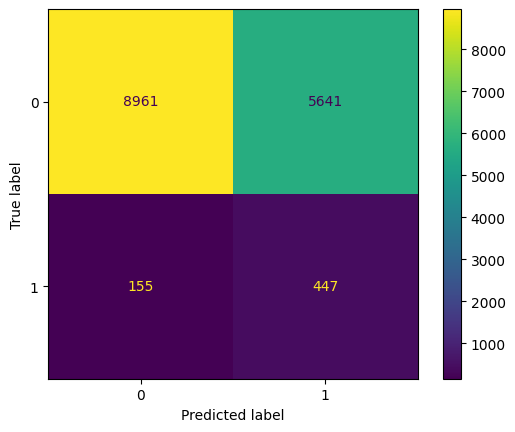

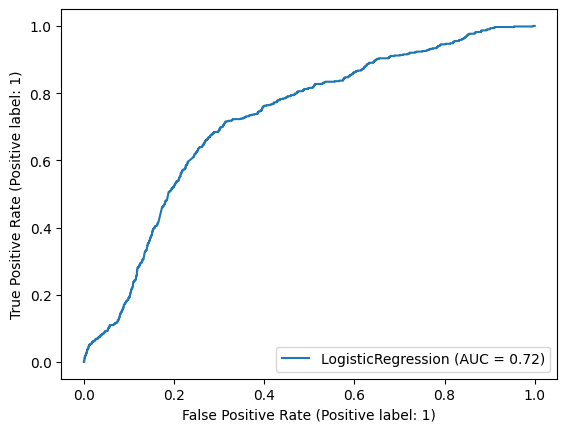

In [26]:
params_lr = {'penalty': 'elasticnet', 'l1_ratio':0.5, 'solver': 'saga'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, tt_lr, lucro_lr = run_model(model_lr, X_over, y_over, X_test, y_test)

# Decision Tree

Acurácia = 0.7106682451986319
ROC Característica de Operação do Receptor = 0.694086983942945
Tempo utilizado = 0.34699034690856934
              precision    recall  f1-score   support

           0    0.98159   0.71209   0.82540     14602
           1    0.08827   0.67608   0.15615       602

    accuracy                        0.71067     15204
   macro avg    0.53493   0.69409   0.49077     15204
weighted avg    0.94622   0.71067   0.79890     15204

Lucro obtido = -5410


c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


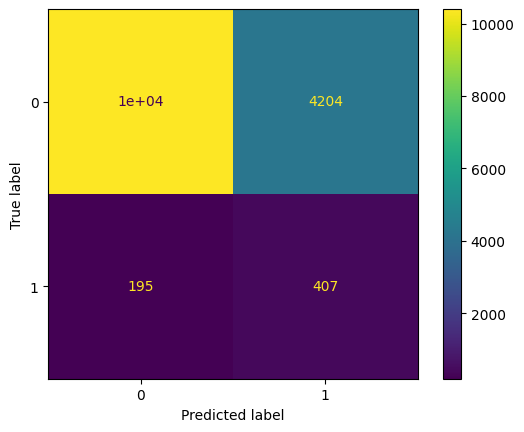

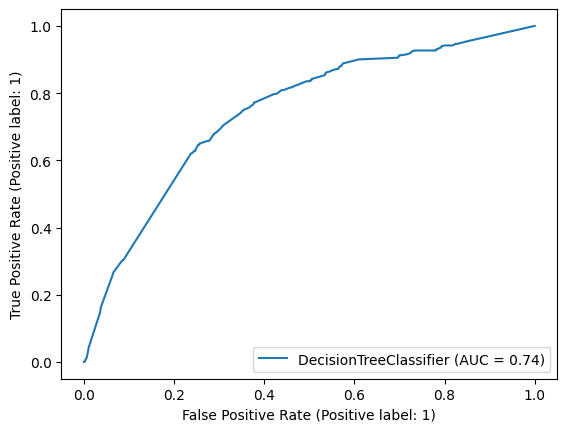

In [29]:
params_dt = {'max_depth': 12,    
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, tt_dt, lucro_dt = run_model(model_dt, X_over, y_over, X_test, y_test)

Acurácia = 0.8495132859773744
ROC Característica de Operação do Receptor = 0.7138142911292814
Tempo utilizado = 20.949724197387695
              precision    recall  f1-score   support

           0    0.97967   0.86118   0.91661     14602
           1    0.14400   0.56645   0.22963       602

    accuracy                        0.84951     15204
   macro avg    0.56183   0.71381   0.57312     15204
weighted avg    0.94658   0.84951   0.88941     15204



c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Lucro obtido = 10420


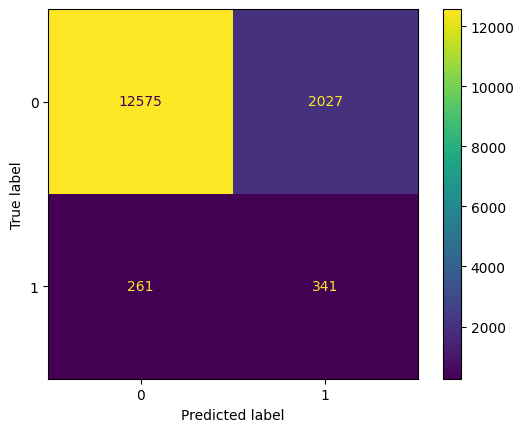

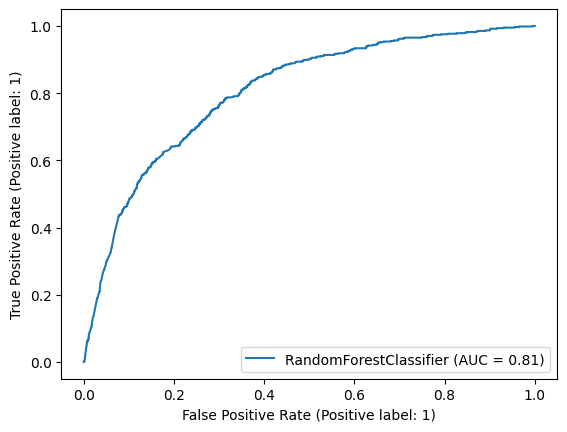

In [31]:
params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, tt_rf, lucro_rf = run_model(model_rf, X_over, y_over, X_test, y_test)

# XGB Classifier

Acurácia = 0.8781241778479347
ROC Característica de Operação do Receptor = 0.6626147103136557
Tempo utilizado = 300.26687598228455
              precision    recall  f1-score   support

           0    0.97440   0.89666   0.93391     14602
           1    0.14601   0.42857   0.21781       602

    accuracy                        0.87812     15204
   macro avg    0.56020   0.66261   0.57586     15204
weighted avg    0.94160   0.87812   0.90556     15204



c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Lucro obtido = 8130


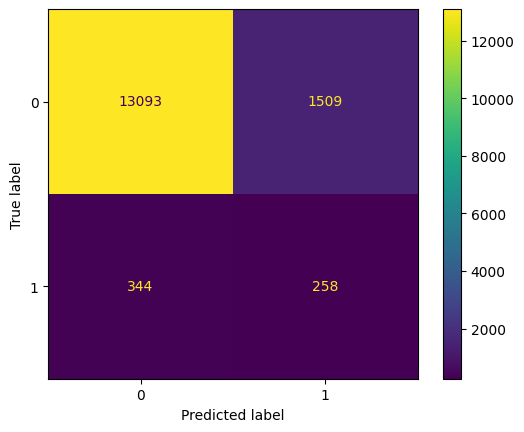

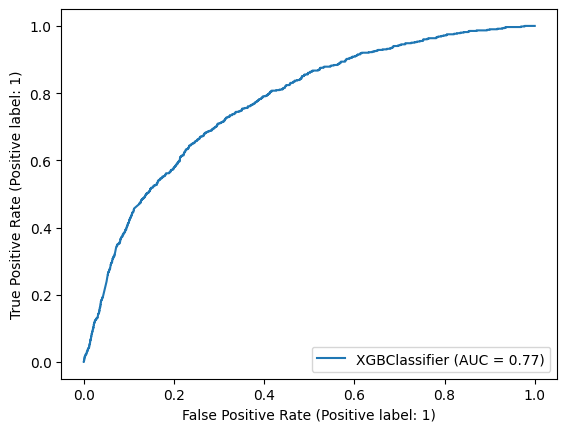

In [33]:

params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, tt_xgb, lucro_xgb = run_model(model_xgb, X_over, y_over, X_test, y_test)

# LightGBM Classifier

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
Acurácia = 0.8680610365693239
ROC Característica de Operação do Receptor = 0.7067477217201849
Tempo utilizado = 9.026898384094238
              precision    recall  f1-score   support

           0    0.97857   0.88193   0.92774     14602
           1    0.15656   0.53156   0.24187       602

    accuracy                        0.86806     15204
   macro avg    0.56756   0.70675   0.58481     15204
weighted avg    0.94602   0.86806   0.90059     15204



c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Lucro obtido = 11560


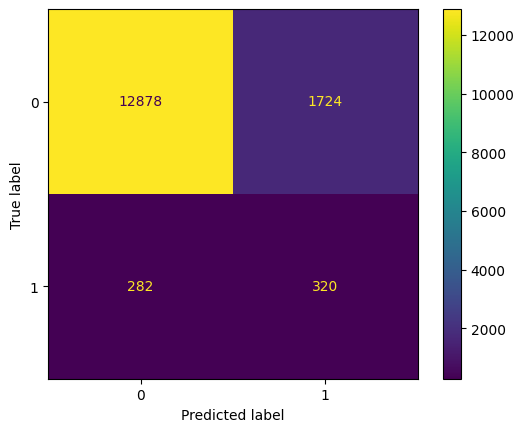

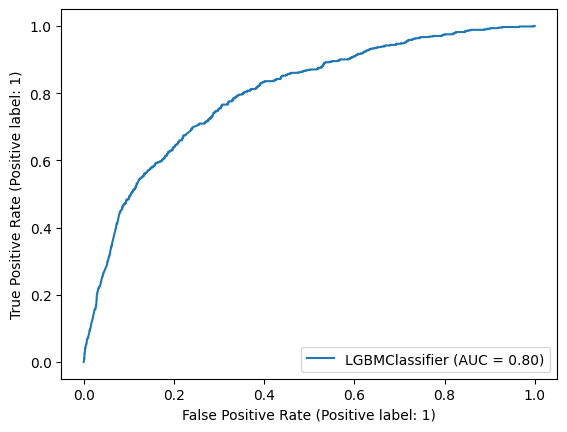

In [35]:
model_lgb = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1.,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      random_state=42
                     )
model_lgb, accuracy_lgb, roc_auc_lgb, tt_lgb, lucro_lgb = run_model(model_lgb, X_over, y_over, X_test, y_test)

# Naive Bayes

Acurácia = 0.14141015522230993
ROC Característica de Operação do Receptor = 0.537876302386102
Tempo utilizado = 0.4355299472808838
              precision    recall  f1-score   support

           0    0.98802   0.10731   0.19360     14602
           1    0.04281   0.96844   0.08200       602

    accuracy                        0.14141     15204
   macro avg    0.51542   0.53788   0.13780     15204
weighted avg    0.95059   0.14141   0.18918     15204

Lucro obtido = -77880


c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


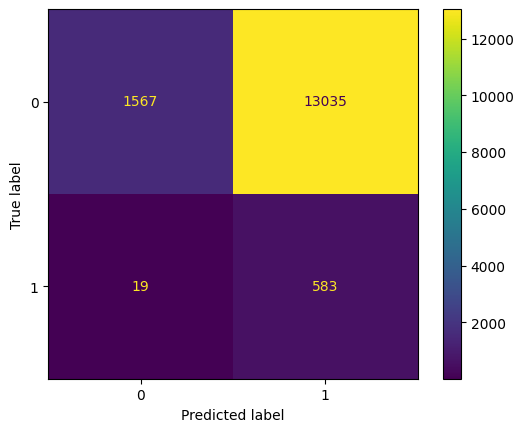

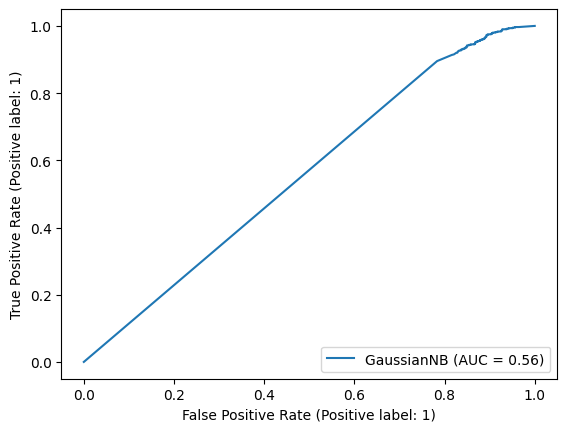

In [37]:
params_nb = {}

model_nb = GaussianNB(**params_nb)
model_nb, accuracy_nb, roc_auc_nb, tt_nb, lucro_nb = run_model(model_nb, X_over, y_over, X_test, y_test)

# KNN

Acurácia = 0.8101157590107866
ROC Característica de Operação do Receptor = 0.6327828618570888
Tempo utilizado = 47.57318925857544
              precision    recall  f1-score   support

           0    0.97280   0.82537   0.89304     14602
           1    0.09414   0.44020   0.15511       602

    accuracy                        0.81012     15204
   macro avg    0.53347   0.63278   0.52407     15204
weighted avg    0.93801   0.81012   0.86382     15204



c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Lucro obtido = -1650


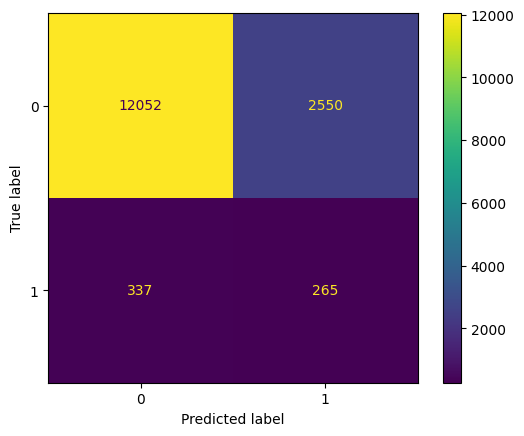

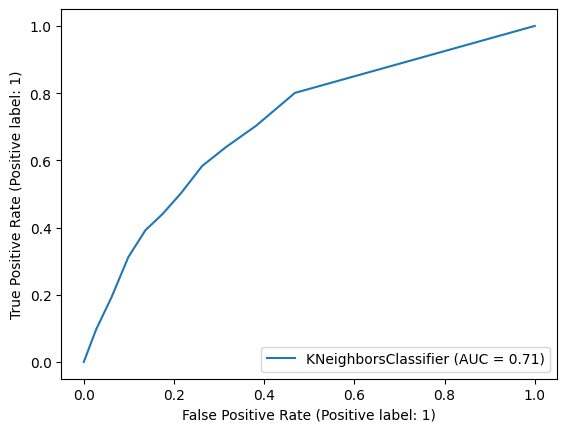

In [46]:
from sklearn.neighbors import KNeighborsClassifier
params_kn = {'n_neighbors':10, 'algorithm': 'kd_tree', 'n_jobs':4}

model_kn = KNeighborsClassifier(**params_kn)
model_kn, accuracy_kn, roc_auc_kn, tt_kn, lucro_kn = run_model(model_kn, X_over, y_over, X_test, y_test)

# Neural Network

c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Acurácia = 0.7836753485924757
ROC Característica de Operação do Receptor = 0.7384660591253827
Tempo utilizado = 142.2173206806183
              precision    recall  f1-score   support

           0    0.98400   0.78756   0.87489     14602
           1    0.11800   0.68937   0.20151       602

    accuracy                        0.78368     15204
   macro avg    0.55100   0.73847   0.53820     15204
weighted avg    0.94971   0.78368   0.84823     15204



c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Lucro obtido = 6330


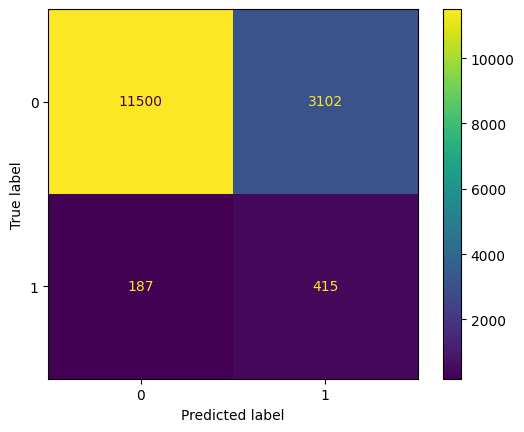

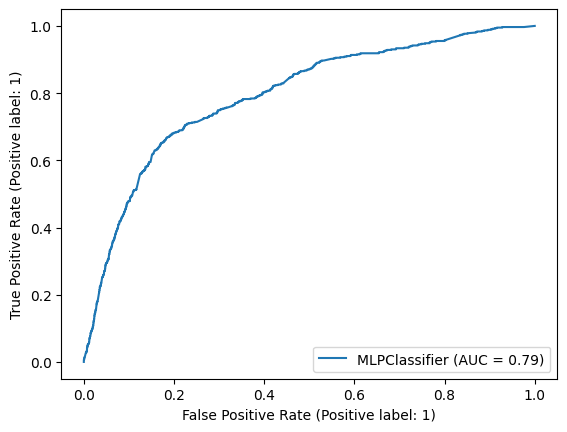

In [39]:
# Neural Network (Multilayer Perceptron)
params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 100}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, tt_nn, lucro_nn = run_model(model_nn, X_over, y_over, X_test, y_test)

# AdaBoost

Acurácia = 0.8424756642988687
ROC Característica de Operação do Receptor = 0.7220952529599323
Tempo utilizado = 183.43804287910461
              precision    recall  f1-score   support

           0    0.98063   0.85283   0.91227     14602
           1    0.14212   0.59136   0.22916       602

    accuracy                        0.84248     15204
   macro avg    0.56137   0.72210   0.57072     15204
weighted avg    0.94743   0.84248   0.88523     15204



c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Lucro obtido = 10550


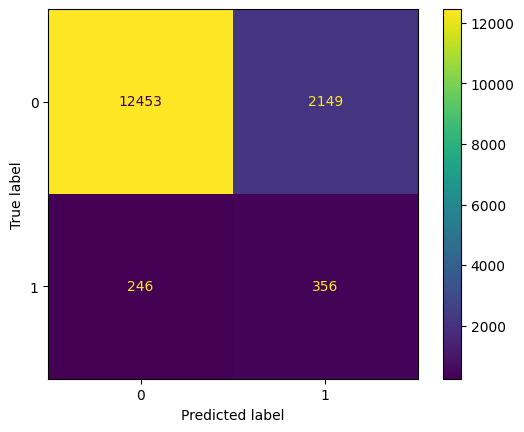

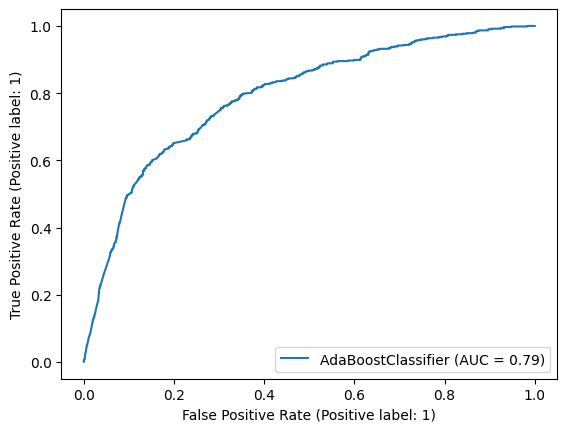

In [42]:


params_adab ={'n_estimators': 500,
              'random_state': 12345}

model_adab = AdaBoostClassifier(**params_adab)
model_adab, accuracy_adab, roc_auc_adab, tt_adab, lucro_adab = run_model(model_adab, X_over, y_over, X_test, y_test)

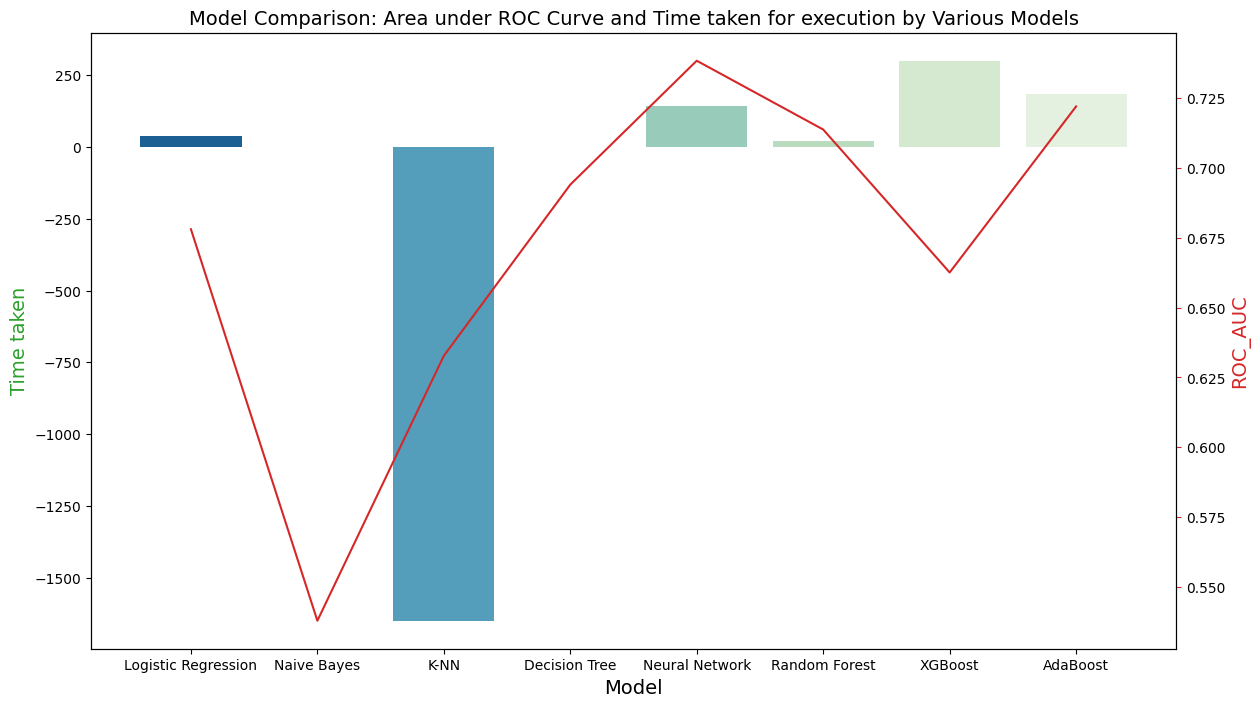

In [43]:
roc_auc_scores = [roc_auc_lr, roc_auc_nb, roc_auc_kn, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_xgb, roc_auc_adab]
tt = [tt_lr, tt_nb, tt_kn, tt_dt, tt_nn, tt_rf, tt_xgb, tt_adab]

model_data = {'Model': ['Logistic Regression','Naive Bayes','K-NN','Decision Tree','Neural Network','Random Forest','XGBoost','AdaBoost'],
              'ROC_AUC': roc_auc_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(14,8))
ax1.set_title('Model Comparison: Area under ROC Curve and Time taken for execution by Various Models', fontsize=14)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=14)
ax1.set_ylabel('Time taken', fontsize=14, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='GnBu_r')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('ROC_AUC', fontsize=14, color=color)
ax2 = sns.lineplot(x='Model', y='ROC_AUC', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

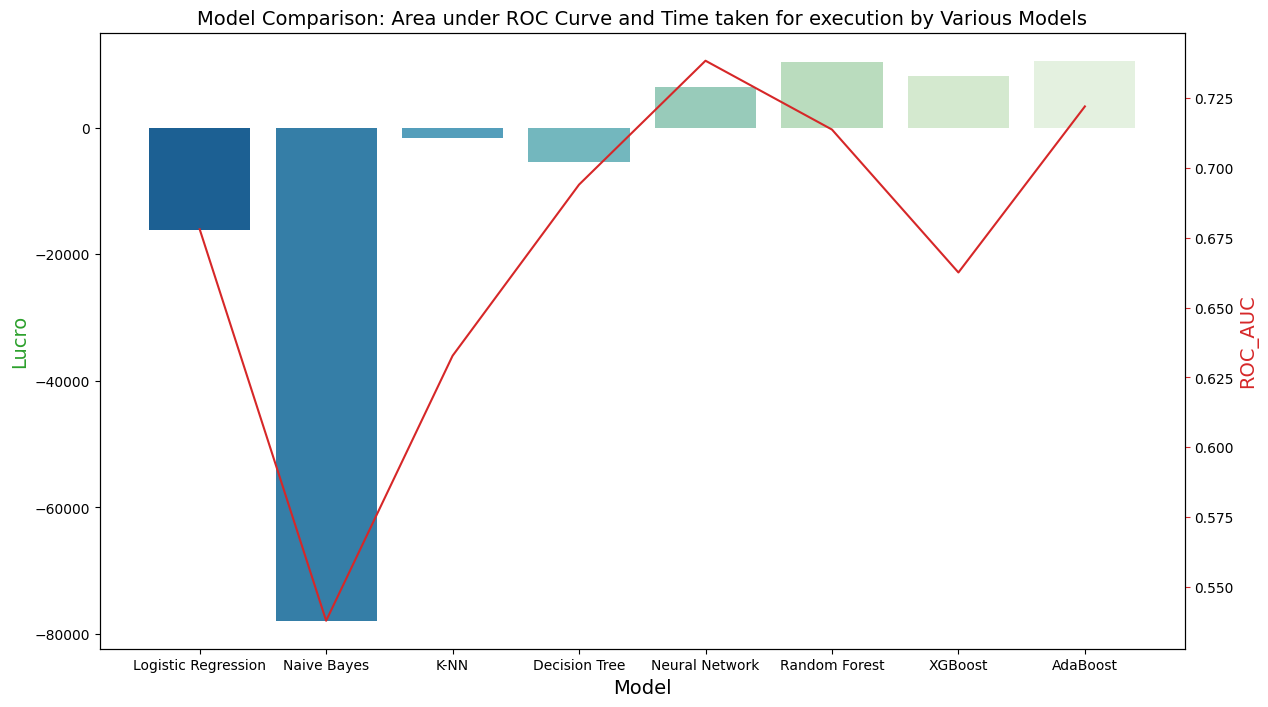

In [48]:
roc_auc_scores = [roc_auc_lr, roc_auc_nb, roc_auc_kn, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_xgb, roc_auc_adab]
lucro = [lucro_lr, lucro_nb, lucro_kn, lucro_dt, lucro_nn, lucro_rf, lucro_xgb, lucro_adab]

model_data = {'Model': ['Logistic Regression','Naive Bayes','K-NN','Decision Tree','Neural Network','Random Forest','XGBoost','AdaBoost'],
              'ROC_AUC': roc_auc_scores,
              'Lucro': lucro}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(14,8))
ax1.set_title('Model Comparison: Area under ROC Curve and Time taken for execution by Various Models', fontsize=14)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=14)
ax1.set_ylabel('Lucro', fontsize=14, color=color)
ax2 = sns.barplot(x='Model', y='Lucro', data = data, palette='GnBu_r')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('ROC_AUC', fontsize=14, color=color)
ax2 = sns.lineplot(x='Model', y='ROC_AUC', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

In [17]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_over):
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_over)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [12]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[1000,2000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }

In [13]:
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
The best auc score was 0.910
The best params were: {'n_estimators': 2000, 'min_samples_split': 100, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 1000}


RandomForestClassifier(class_weight='balanced', max_depth=1000,
                       max_leaf_nodes=250, min_samples_leaf=3,
                       min_samples_split=100, n_estimators=2000)

Acurácia = 0.8431991581162852
ROC Característica de Operação do Receptor = 0.7328241113832767
Tempo utilizado = 323.53302001953125
              precision    recall  f1-score   support

           0    0.98163   0.85269   0.91263     14602
           1    0.14643   0.61296   0.23639       602

    accuracy                        0.84320     15204
   macro avg    0.56403   0.73282   0.57451     15204
weighted avg    0.94856   0.84320   0.88585     15204



c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Lucro obtido = 11700


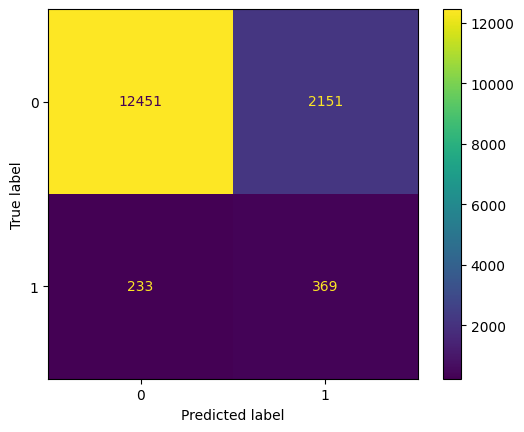

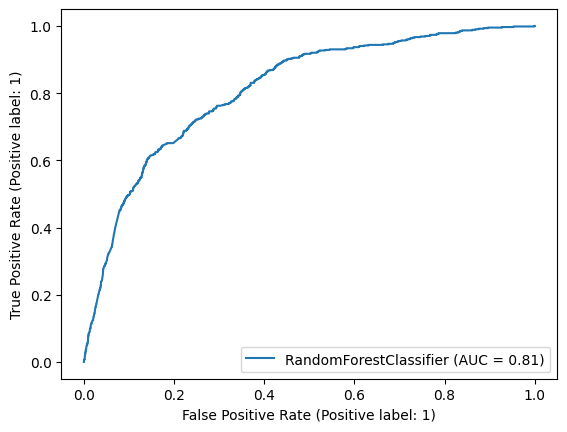

In [17]:
params_rf = {'class_weight':'balanced',
             'max_leaf_nodes':250,
             'max_depth': 1000,
             'min_samples_leaf': 3,
             'min_samples_split': 100,
             'n_estimators': 2000,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, tt_rf, lucro_rf = run_model(model_rf, X_over, y_over, X_test, y_test)

In [9]:
# model_adab = AdaBoostClassifier(**params_adab)

model_adab_hyp = AdaBoostClassifier()
params = { 'n_estimators':[10, 50, 100, 500, 1000, 1500, 2000]}


In [19]:
find_best_params(model_adab_hyp,params,cv=3)

C:\users\t696994\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 7 candidates, totalling 21 fits
The best auc score was 0.934
The best params were: {'n_estimators': 2000}


AdaBoostClassifier(n_estimators=2000)

Acurácia = 0.8489213364903972
ROC Característica de Operação do Receptor = 0.7103208225697022
Tempo utilizado = 862.2296390533447
              precision    recall  f1-score   support

           0    0.97935   0.86084   0.91628     14602
           1    0.14225   0.55980   0.22686       602

    accuracy                        0.84892     15204
   macro avg    0.56080   0.71032   0.57157     15204
weighted avg    0.94621   0.84892   0.88898     15204



C:\users\t696994\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\users\t696994\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Lucro obtido = 10010


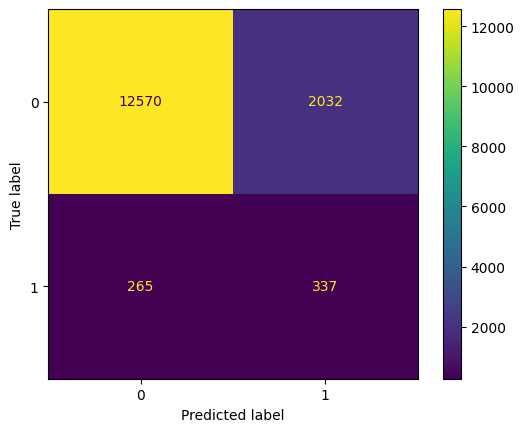

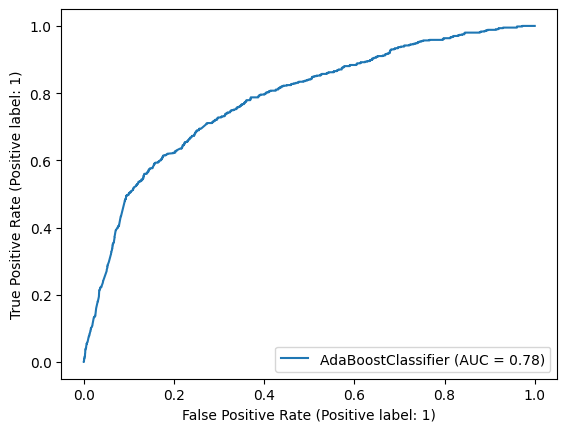

In [22]:

params_adab ={'n_estimators': 2000,
              'random_state': 12345}

model_adab = AdaBoostClassifier(**params_adab)
model_adab, accuracy_adab, roc_auc_adab, tt_adab, lucro_adab = run_model(model_adab, X_over, y_over, X_test, y_test)

In [6]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.1)

In [25]:
gradient_booster.fit(X_over,y_over)

GradientBoostingClassifier()

In [26]:
print(classification_report(y_test,gradient_booster.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     14602
           1       0.15      0.56      0.24       602

    accuracy                           0.86     15204
   macro avg       0.57      0.72      0.58     15204
weighted avg       0.95      0.86      0.90     15204



Acurácia = 0.8599710602473033
ROC Característica de Operação do Receptor = 0.7184624278929614
Tempo utilizado = 79.23795676231384
              precision    recall  f1-score   support

           0    0.97984   0.87214   0.92286     14602
           1    0.15406   0.56478   0.24208       602

    accuracy                        0.85997     15204
   macro avg    0.56695   0.71846   0.58247     15204
weighted avg    0.94714   0.85997   0.89590     15204



C:\users\t696994\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\users\t696994\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Lucro obtido = 11930


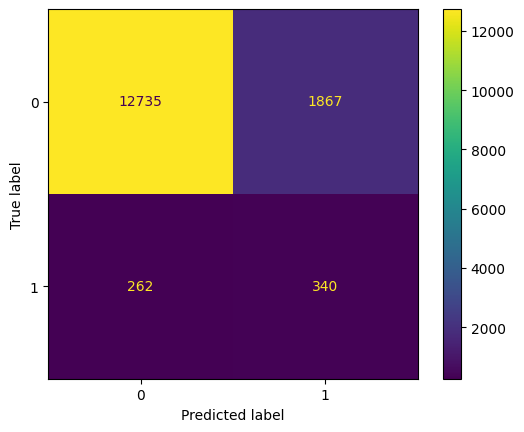

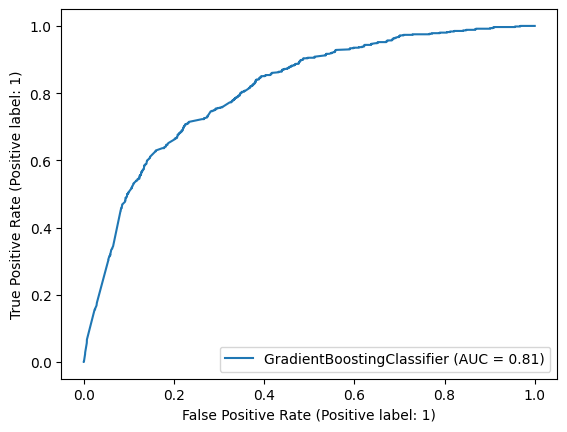

In [27]:
model_gb, accuracy_gb, roc_auc_gb, tt_gb, lucro_gb = run_model(gradient_booster, X_over, y_over, X_test, y_test)

In [28]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(gbc,parameters,cv=5)
cv.fit(X_train, y_train)

In [12]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.1)

In [13]:
gradient_booster.fit(X_train, y_train)

GradientBoostingClassifier()

Acurácia = 0.9599447513812155
ROC Característica de Operação do Receptor = 0.502945598404806
Tempo utilizado = 31.960307836532593
              precision    recall  f1-score   support

           0    0.96063   0.99925   0.97956     14602
           1    0.26667   0.00664   0.01297       602

    accuracy                        0.95994     15204
   macro avg    0.61365   0.50295   0.49626     15204
weighted avg    0.93315   0.95994   0.94129     15204

Lucro obtido = 250


c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


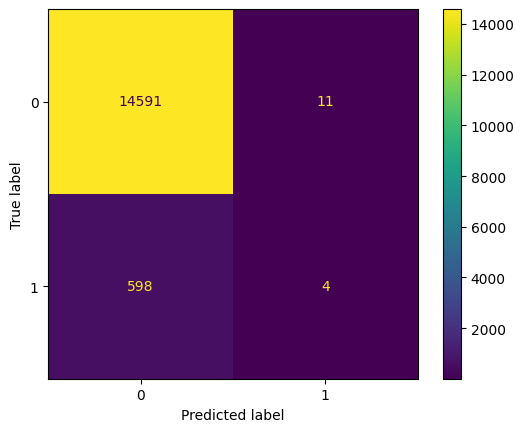

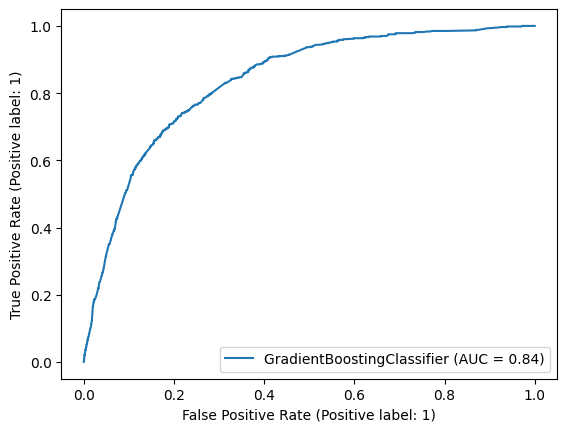

In [14]:
model_gb, accuracy_gb, roc_auc_gb, tt_gb, lucro_gb = run_model(gradient_booster, X_train, y_train, X_test, y_test)

Hyperparameters Tunning Neural Network

In [8]:
# Create function
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    def nn_cl_fun():
        opt = Adam(lr = learning_rate)
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=10, activation=activation))
        nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [9]:

score_acc = make_scorer(accuracy_score)

In [10]:
# Set paramaters
params_nn ={
    'neurons': (140, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  epochs   | learni... |  neurons  | optimizer |
-------------------------------------------------------------------------------------------------


c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\optimizers\optimizer_v2\adadelta.py:82: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\opti

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\gabri\AppData\Local\Temp\__autograph_generated_fileo6vz0wpb.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 10), found shape=(None, 140)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\gabri\AppData\Local\Temp\__autograph_generated_fileo6vz0wpb.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 10), found shape=(None, 140)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\gabri\AppData\Local\Temp\__autograph_generated_fileo6vz0wpb.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 10), found shape=(None, 140)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\gabri\AppData\Local\Temp\__autograph_generated_fileo6vz0wpb.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 10), found shape=(None, 140)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\gabri\AppData\Local\Temp\__autograph_generated_fileo6vz0wpb.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 10), found shape=(None, 140)



In [11]:
def create_model():
 # create model
 model = Sequential()
 model.add(Dense(12, input_shape=(140,), activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

In [12]:
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

In [13]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=1)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_over, y_over)

C:\Users\gabri\AppData\Local\Temp\ipykernel_51808\2266802714.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=1)
c:\users\gabri\appdata\local\programs\python\python39\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/100
1461/1461 [==============================] - 2s 1ms/step - loss: 31.3923 - accuracy: 0.6828
Epoch 2/100
1461/1461 [==============================] - 2s 1ms/step - loss: 18.4621 - accuracy: 0.7066
Epoch 3/100
1461/1461 [==============================] - 2s 1ms/step - loss: 12.5625 - accuracy: 0.7125
Epoch 4/100
1461/1461 [==============================] - 2s 1ms/step - loss: 12.0875 - accuracy: 0.7111
Epoch 5/100
1461/1461 [==============================] - 2s 1ms/step - loss: 8.0279 - accuracy: 0.7088
Epoch 6/100
1461/1461 [==============================] - 2s 1ms/step - loss: 4.1959 - accuracy: 0.7053
Epoch 7/100
1461/1461 [==============================] - 1s 979us/step - loss: 3.6000 - accuracy: 0.7090
Epoch 8/100
1461/1461 [==============================] - 2s 1ms/step - loss: 3.6796 - accuracy: 0.7102
Epoch 9/100
1461/1461 [==============================] - 3s 2ms/step - loss: 2.6504 - accuracy: 0.7117
Epoch 10/100
1461/1461 [==============================] - 2s 2ms/st

1461/1461 [==============================] - 2s 1ms/step - loss: 0.5231 - accuracy: 0.7795
Epoch 80/100
1461/1461 [==============================] - 1s 884us/step - loss: 0.4782 - accuracy: 0.7789
Epoch 81/100
1461/1461 [==============================] - 2s 1ms/step - loss: 0.4948 - accuracy: 0.7794
Epoch 82/100
1461/1461 [==============================] - 2s 1ms/step - loss: 0.4928 - accuracy: 0.7803
Epoch 83/100
1461/1461 [==============================] - 2s 1ms/step - loss: 0.4824 - accuracy: 0.7792
Epoch 84/100
1461/1461 [==============================] - 1s 980us/step - loss: 0.5011 - accuracy: 0.7778
Epoch 85/100
1461/1461 [==============================] - 2s 1ms/step - loss: 0.4869 - accuracy: 0.7812
Epoch 86/100
1461/1461 [==============================] - 2s 1ms/step - loss: 0.4815 - accuracy: 0.7791
Epoch 87/100
1461/1461 [==============================] - 2s 1ms/step - loss: 0.4859 - accuracy: 0.7789
Epoch 88/100
1461/1461 [==============================] - 2s 1ms/step - l

In [14]:


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.676357 using {'batch_size': 80, 'epochs': 100}
0.499384 (0.175957) with: {'batch_size': 10, 'epochs': 10}
0.521503 (0.184576) with: {'batch_size': 10, 'epochs': 50}
0.567762 (0.156551) with: {'batch_size': 10, 'epochs': 100}
0.440259 (0.214451) with: {'batch_size': 20, 'epochs': 10}
0.537185 (0.184030) with: {'batch_size': 20, 'epochs': 50}
0.556788 (0.163869) with: {'batch_size': 20, 'epochs': 100}
0.496696 (0.190694) with: {'batch_size': 40, 'epochs': 10}
0.527923 (0.169838) with: {'batch_size': 40, 'epochs': 50}
0.542527 (0.169419) with: {'batch_size': 40, 'epochs': 100}
0.472479 (0.185065) with: {'batch_size': 60, 'epochs': 10}
0.539702 (0.161920) with: {'batch_size': 60, 'epochs': 50}
0.563225 (0.150623) with: {'batch_size': 60, 'epochs': 100}
0.480175 (0.179010) with: {'batch_size': 80, 'epochs': 10}
0.555975 (0.160374) with: {'batch_size': 80, 'epochs': 50}
0.676357 (0.078164) with: {'batch_size': 80, 'epochs': 100}
0.452072 (0.166363) with: {'batch_size': 100, 'epochs':

In [ ]:
# Set paramaters
params_nn_opt ={
    'batch_size':80,
    'epochs':10,
    'activation': 'logistic'
}

# model_nn_opt = MLPClassifier(**params_nn_opt)
model_nn_opt, accuracy_nn_opt, roc_auc_nn_opt, tt_nn_opt, lucro_nn_opt = run_model(grid_result, X_over, y_over, X_test, y_test)

In [16]:
grid_result

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000002779789F1C0>,
             n_jobs=-1,
             param_grid={'batch_size': [10, 20, 40, 60, 80, 100],
                         'epochs': [10, 50, 100]})